pretendo usar um decoder para tratar das soluções que não são válidas.

The order crossover operator [92] was designed by Davis for order-based permutation problems. It begins in a similar fashion to PMX, by copying a
randomly chosen segment of the first parent into the offspring. However, it
proceeds differently because the intention is to transmit information about
relative order from the second parent.
1. Choose two crossover points at random, and copy the segment between
them from the first parent (PI) into the first offspring.
2. Starting from the second crossover point in the second parent, copy the
remaining unused numbers into the first child in the order that they appear
in the second parent, wrapping around at the end of the list.
3. Create the second offspring in an analogous manner, with the parent roles
reversed. 

In [3]:
import random

In [106]:
class Operation:
	def __init__(self, id, machine, processing_time):
		self.id = id
		self.machine = {machine}  # Set containing the single machine this operation can use
		self.processing_times = {machine: processing_time}

	def able(self, machine):
		return machine in self.machine

	def get_processing_time(self, machine):
		return self.processing_times.get(machine, 0)

class Job:
	def __init__(self, id, operations):
		self.id = id
		self.operations = operations  # List of Operation objects in order of precedence

class JobShopSolution:
	def __init__(self, jobs, machines, genotype):
		self.genotype = genotype
		self.jobs = jobs
		self.machines = machines
		#phenotype = schedule

		self.fitness, self.phenotype = self.build_schedule()

	def get_fitness(self):
		return self.fitness

	def build_schedule(self):
		# Dictionary to track when each machine will be free
		machine_end_times = {machine: 0 for machine in self.machines}
		# Dictionary to track when each job's previous operation finished
		job_end_times = {job.id: 0 for job in self.jobs}

		schedule = []
		operation_by_job = {} #mapeia as operações pelos job ids
		operation_positions = {}  # Track position of operation in its job para guardar precedencia

		# Build operation mappings
		for job in self.jobs:
			for i, operation in enumerate(job.operations):
				operation_by_job[operation] = job.id #qual job a operacao pertence
				operation_positions[operation] = i #qual posicao a operacao tem no job

		for operation in self.genotype: #cada operacao do cromossomo
			job_id = operation_by_job[operation] #o job da operacao
			machine = next(iter(operation.machine)) # a maquina da operacao
			position = operation_positions[operation] #a posicao da operacao no job

			# Find the job this operation belongs to
			current_job = next(job for job in self.jobs if job.id == job_id)

			# If this isn't the first operation in the job, ensure all predecessors are completed
			if position > 0:
				predecessor = current_job.operations[position - 1]
				# Find when the predecessor operation ended
				for prev_op, prev_machine, prev_start, prev_end in schedule:
					if prev_op == predecessor:
						job_end_times[job_id] = max(job_end_times[job_id], prev_end) #atualiza o endtime do job com base no endtime do predecessor
						break

			processing_time = operation.get_processing_time(machine) #pega o tempo de processamento da operacao
			start_time = max(machine_end_times[machine], job_end_times[job_id]) # começa a operacao quando a maquina fica livre ou o job anterior termina
			end_time = start_time + processing_time #calcula o endtime da operacao
			machine_end_times[machine] = end_time #atualiza o endtime da maquina
			job_end_times[job_id] = end_time #atualzia o endtime do job

			schedule.append((operation, machine, start_time, end_time))

		# Calculate makespan as the maximum end time across all machines
		makespan = max(machine_end_times.values())

		# Return negative makespan as fitness (since we want to minimize makespan)
		return -makespan, schedule

In [101]:
def initialize_population(population_size, jobs):
    population = []

    for _ in range(population_size):
        # Create mappings for tracking operation order
        operation_by_job = {}
        operation_positions = {}
        for job in jobs:
            for i, operation in enumerate(job.operations):
                operation_by_job[operation] = job.id
                operation_positions[operation] = i

        chromossome = []
        available_operations = []
        job_progress = {job.id: 0 for job in jobs}  # Track progress in each job

        # Initialize with first operation from each job
        for job in jobs:
            if job.operations:
                available_operations.append(job.operations[0])

        while available_operations:
            # Select random operation from available ones
            operation = random.choice(available_operations)
            chromossome.append(operation)
            available_operations.remove(operation)

            # Update job progress
            job_id = operation_by_job[operation]
            job_progress[job_id] += 1

            # Find the corresponding job
            current_job = next(job for job in jobs if job.id == job_id)

            # If there's a next operation in this job, make it available
            if job_progress[job_id] < len(current_job.operations):
                next_operation = current_job.operations[job_progress[job_id]]
                available_operations.append(next_operation)

        population.append(chromossome)

    return population

def tournament(population, k):
	individuals = random.sample(population, k)
	return max(individuals, key=lambda x : x.get_fitness())

#Crossover: Order-based crossover (keeps valid permutations).
#acompanha os constraints de ordem entre as operações
# trata diretamente com os cromossomos
def order_based_crossover(parent1, parent2, jobs):
    length = len(parent1)
    point1 = random.randint(0, length-2)
    point2 = random.randint(point1+1, length-1)

    # Create operation mappings
    operation_by_job = {}
    operation_positions = {}
    for job in jobs:
        for i, operation in enumerate(job.operations):
            operation_by_job[operation] = job.id
            operation_positions[operation] = i

    # Initialize offspring with None
    offspring1 = [None] * length
    offspring2 = [None] * length

    # Track operations added for each job
    job_progress1 = {job.id: 0 for job in jobs}
    job_progress2 = {job.id: 0 for job in jobs}

    # First, try to copy segment maintaining precedence
    for i in range(point1, point2):
        op1 = parent1[i]
        op2 = parent2[i]

        # For offspring1
        job_id1 = operation_by_job[op1]
        if operation_positions[op1] == job_progress1[job_id1]:
            offspring1[i] = op1
            job_progress1[job_id1] += 1

        # For offspring2
        job_id2 = operation_by_job[op2]
        if operation_positions[op2] == job_progress2[job_id2]:
            offspring2[i] = op2
            job_progress2[job_id2] += 1

    # Fill remaining positions
    def fill_remaining(offspring, parent, job_progress):
        # First, fill with operations from parent that maintain precedence
        for op in parent:
            if op not in offspring:
                job_id = operation_by_job[op]
                if operation_positions[op] == job_progress[job_id]:
                    # Find first empty position
                    for i in range(length):
                        if offspring[i] is None:
                            offspring[i] = op
                            job_progress[job_id] += 1
                            break

        # Fill any remaining positions with valid operations
        for job in jobs:
            while job_progress[job.id] < len(job.operations):
                next_op = job.operations[job_progress[job.id]]
                # Find first empty position
                for i in range(length):
                    if offspring[i] is None:
                        offspring[i] = next_op
                        job_progress[job.id] += 1
                        break

    # Fill remaining positions in both offspring
    fill_remaining(offspring1, parent2, job_progress1)
    fill_remaining(offspring2, parent1, job_progress2)

    return offspring1, offspring2

def mutation(chromossome, jobs):
    # Create operation mappings
    operation_by_job = {}
    operation_positions = {}
    for job in jobs:
        for i, operation in enumerate(job.operations):
            operation_by_job[operation] = job.id
            operation_positions[operation] = i

    length = len(chromossome)
    # Try up to length times to find valid swap
    for _ in range(length):
        point1 = random.randint(0, length-1)
        point2 = random.randint(0, length-1)

        if point1 == point2:
            continue

        op1 = chromossome[point1]
        op2 = chromossome[point2]

        # Get jobs and positions for both operations
        job_id1 = operation_by_job[op1]
        job_id2 = operation_by_job[op2]

        # Skip if same job
        if job_id1 == job_id2:
            continue

        # Create temporary chromosome with swap to check validity
        temp_chrom = chromossome.copy()
        temp_chrom[point1], temp_chrom[point2] = temp_chrom[point2], temp_chrom[point1]

        # Check if swap maintains precedence for both jobs
        valid = True
        for job in jobs:
            job_ops = [op for op in temp_chrom if operation_by_job[op] == job.id]
            # Check if operations appear in correct order
            for i in range(len(job_ops)-1):
                if operation_positions[job_ops[i]] > operation_positions[job_ops[i+1]]:
                    valid = False
                    break
            if not valid:
                break

        if valid:
            # If valid, perform the swap
            chromossome[point1], chromossome[point2] = chromossome[point2], chromossome[point1]
            break

    return chromossome

def genetic_algorithm(jobs,machines,population_size,generations, crossover_rate, mutation_rate):
	population = initialize_population(population_size, jobs)
	best_solution = None
	best_fitness = float('-inf')
	average_fitness_by_generation = []
	scores = []

    # Evaluate first population
	population = [JobShopSolution(jobs, machines, chromossome) for chromossome in population]#cada cromossomo eh um objeto solution
	for individual in population:
		current_fitness = individual.get_fitness()
		scores.append(current_fitness)
		if current_fitness > best_fitness:
			best_fitness = current_fitness
			best_solution = individual

	average_fitness_by_generation.append(sum(scores)/len(scores))

	for _ in range(generations):
		new_population = []
		while len(new_population) < population_size:
			if random.random() < crossover_rate:
				parent1 = tournament(population, 2)
				parent2 = tournament(population, 2)

				offspring1, offspring2 = order_based_crossover(parent1.genotype, parent2.genotype, jobs)
				if random.random() < mutation_rate:
					offspring1 = mutation(offspring1, jobs)
				if random.random() < mutation_rate:
					offspring2 = mutation(offspring2, jobs)

				# Create JobShopSolution objects for the offspring
				new_population.extend([
					JobShopSolution(jobs, machines, offspring1),
					JobShopSolution(jobs, machines, offspring2)
				])
			else:
				chromossome = tournament(population, 2)
				if random.random() < mutation_rate:
					mutated_chromossome = mutation(chromossome.genotype, jobs)
					new_population.append(JobShopSolution(jobs, machines, mutated_chromossome))
				else:
					new_population.append(JobShopSolution(jobs, machines, chromossome.genotype))
		#avalia nova populacao
		population = new_population
		scores = [ind.get_fitness() for ind in population]  # Get scores for new population
		best_solution = max(population, key=lambda x: x.get_fitness())
		best_fitness = best_solution.get_fitness()
		average_fitness_by_generation.append(sum(scores)/len(scores))

	return best_solution, best_fitness, average_fitness_by_generation, scores


Best fitness (makespan): 11

Best schedule:
Operation 3 on Machine 3 from time 7 to 11


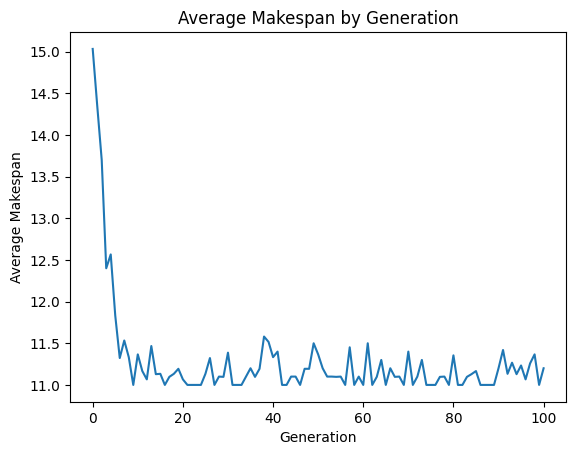

In [108]:
# Create machines
M1 = 1
M2 = 2
M3 = 3
machines = {M1, M2, M3}

# Create operations with (id, machine, processing_time)
# Job 1 operations
O1 = Operation(1, M1, 3)  # Operation 1 on Machine 1, takes 3 units
O2 = Operation(2, M2, 2)  # Operation 2 on Machine 2, takes 2 units
O3 = Operation(3, M3, 4)  # Operation 3 on Machine 3, takes 4 units

# Job 2 operations
O4 = Operation(4, M2, 3)  # Operation 4 on Machine 2, takes 3 units
O5 = Operation(5, M3, 3)  # Operation 5 on Machine 3, takes 3 units
O6 = Operation(6, M1, 2)  # Operation 6 on Machine 1, takes 2 units

# Job 3 operations
O7 = Operation(7, M3, 4)  # Operation 7 on Machine 3, takes 4 units
O8 = Operation(8, M1, 1)  # Operation 8 on Machine 1, takes 1 unit
O9 = Operation(9, M2, 3)  # Operation 9 on Machine 2, takes 3 units

# Create jobs with their operations in order of precedence
J1 = Job(1, [O1, O2, O3])  # Job 1: O1 -> O2 -> O3
J2 = Job(2, [O4, O5, O6])  # Job 2: O4 -> O5 -> O6
J3 = Job(3, [O7, O8, O9])  # Job 3: O7 -> O8 -> O9

jobs = [J1, J2, J3]

# Genetic Algorithm parameters
POPULATION_SIZE = 30
GENERATIONS = 100  # Increased generations for better convergence
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.2

# Run the genetic algorithm
best_solution, best_fitness, fitness_history, scores = genetic_algorithm(
    jobs=jobs,
    machines=machines,
    population_size=POPULATION_SIZE,
    generations=GENERATIONS,
    crossover_rate=CROSSOVER_RATE,
    mutation_rate=MUTATION_RATE
)

# Print results
print(f"Best fitness (makespan): {-best_fitness}")  # Negate to show actual makespan
print("\nBest schedule:")
for operation, machine, start, end in best_solution.phenotype:
    print(f"Operation {operation.id} on Machine {machine} from time {start} to {end}")

# Plot fitness history
import matplotlib.pyplot as plt

plt.plot([-x for x in fitness_history])  # Negate values to show actual makespan
plt.title('Average Makespan by Generation')
plt.xlabel('Generation')
plt.ylabel('Average Makespan')
plt.show()